In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pymc as pm

from modules.models.chapter_5 import estimate_pearson_correlation, estimate_k_coef_agreement, estimate_change_point
from modules.models.chapter_5 import estimate_censored_data, estimate_recapture

from modules.utils import validate_model, visualize_biv_samples, visualize_samples, visualize_time_series

In [3]:
PRPC_KWARGS={
    'samples': 1000
}
SAMPLING_KWARGS={
    'draws': 1000,
    'tune': 3000,
}
POPC_KWARGS={
}

# Estimate Pearson Correlation

Sampling: [Cholesky decomposition, measurements, mu]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Cholesky decomposition, mu]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 118 seconds.
Sampling: [measurements]


/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: divide by zero encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: invalid value encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:699: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/densit

OverflowError: cannot convert float infinity to integer

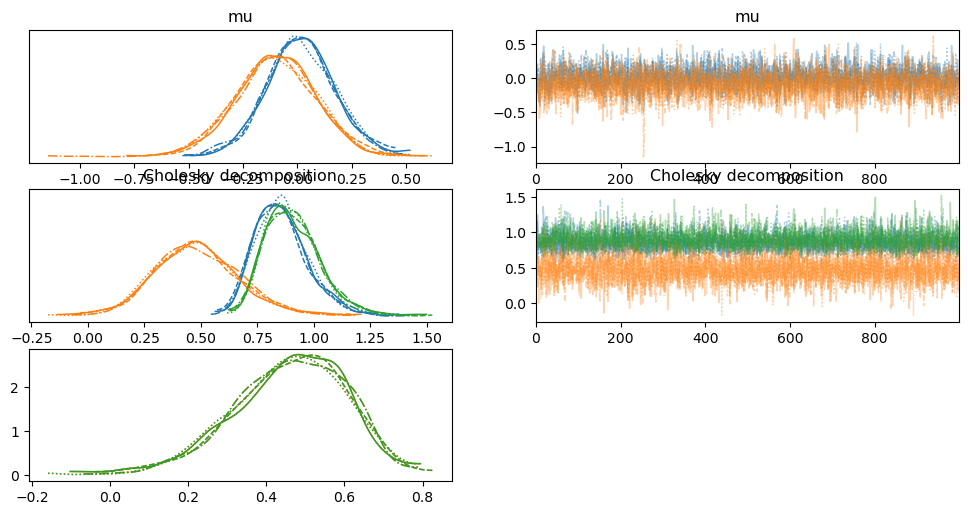

In [4]:
corr = 0.5
obs_measurements = np.random.multivariate_normal(
    mean=[0, 0],
    cov = [[1, corr], [corr, 1]],
    size=30
)

model = estimate_pearson_correlation(
    obs_measurements=obs_measurements, 
    lkj_chol_kwargs={
        'eta': 1,
        'sd_dist': pm.HalfCauchy.dist(25)
    }, 
    mu_kwargs={
        'mu': 0,
        'sigma': 1
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

In [5]:
visualize_biv_samples(
    observed=obs_measurements, 
    prpc=prpc['measurements'].values.mean(0).mean(0), 
    popc=popc['measurements'].values.mean(0).mean(0),
    s=40
)

NameError: name 'prpc' is not defined

## Estimate Correlation for noisy data

Sampling: [Cholesky decomposition, latent_measurements, measurements, measurements_error, mu]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Cholesky decomposition, mu, latent_measurements, measurements_error]


/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 186 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The 

/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: divide by zero encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:980: RuntimeWarning: invalid value encountered in divide
  hist_dens = hist / (hist.sum() * np.diff(bin_edges))
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/density_utils.py:699: RuntimeWarning: divide by zero encountered in divide
  f = grid_counts / bin_width / len(x)
/home/penthotal/mambaforge-pypy3/envs/bayes_env/lib/python3.11/site-packages/arviz/stats/densit

OverflowError: cannot convert float infinity to integer

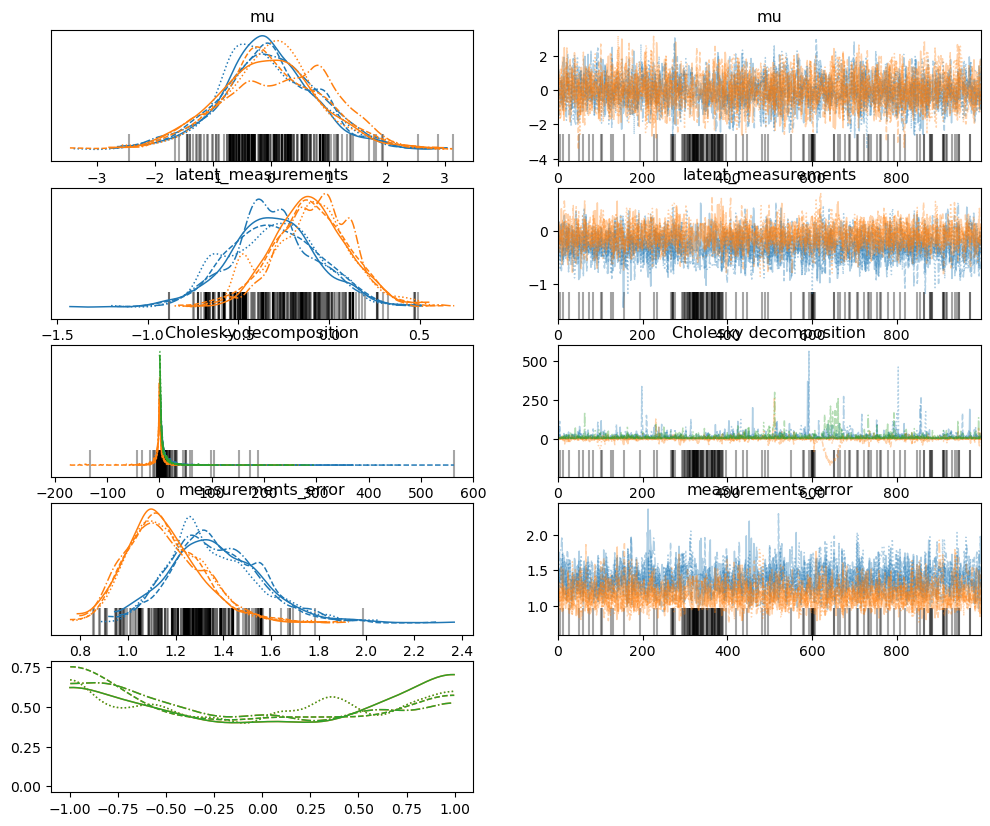

In [6]:
corr = 0.5
obs_measurements = np.random.multivariate_normal(
    mean=[0, 0],
    cov = [[1, 1*corr], [1*corr, 1]],
    size=30
)
obs_measurements += np.random.normal(0, 1, size=(30, 2))

model = estimate_pearson_correlation(
    obs_measurements=obs_measurements, 
    lkj_chol_kwargs={
        'eta': 1,
        'sd_dist': pm.HalfCauchy.dist(25)
    }, 
    mu_kwargs={
        'mu': 0,
        'sigma': 1
    },
    sigma_kwargs={
        'beta': 25
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

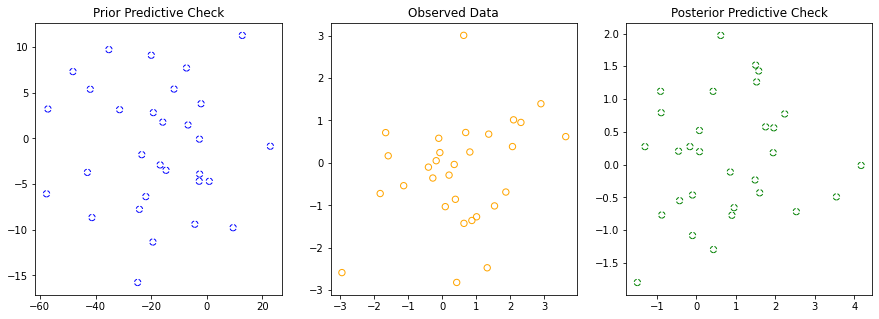

In [7]:
visualize_biv_samples(
    observed=obs_measurements, 
    prpc=prpc['measurements'][0, :, :], 
    popc=popc['measurements'][0, :, :],
    s=40
)

# Estimate K Coefficient of agreement between judges

In [7]:
obs_frequencies = np.array([40, 30, 8, 19])

model = estimate_k_coef_agreement(
    obs_frequencies=obs_frequencies, 
    alpha=5,
    beta=5
)
plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

Sampling: [alpha, beta, gamma, obs_frequencies]


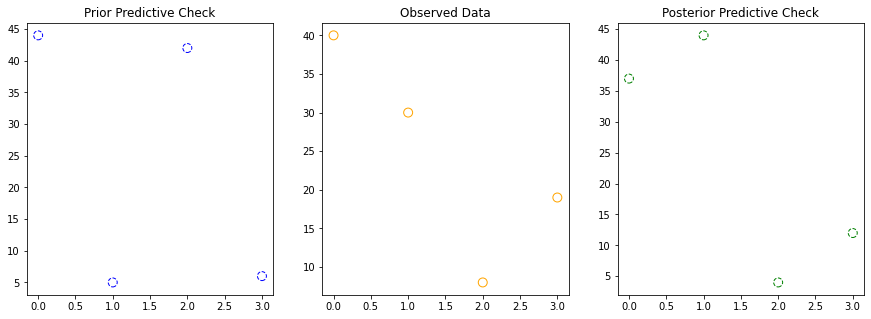

In [9]:
visualize_samples(
    observed=obs_frequencies, 
    prpc=prpc['obs_frequencies'].values.mean(0).mean(0), 
    popc=popc['obs_frequencies'].values.mean(0).mean(0),
    s=80
)

# Estimate Change Point in Time Series

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, intercepts, slope]
>Metropolis: [change_point]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 40 seconds.
The acceptance probability does not match the target. It is 0.8980857805417045, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


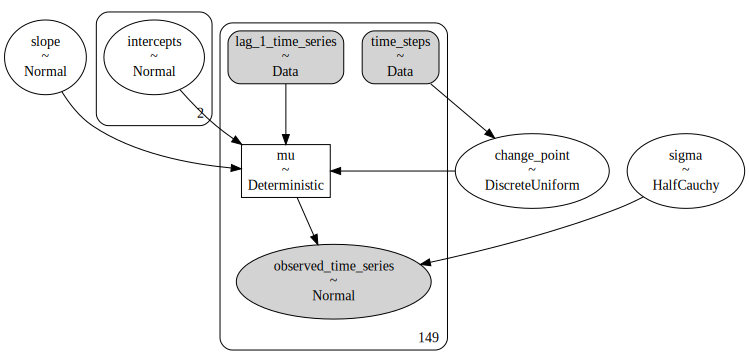

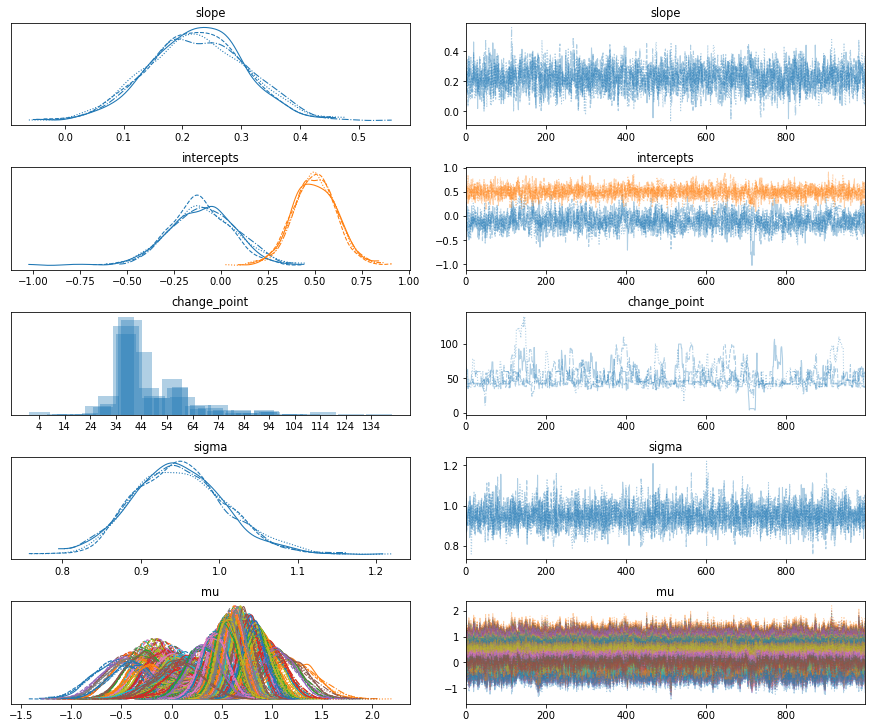

In [10]:
TS_POPC_KWARGS = {
    'samples': 1000,
    'var_names': ['observed_time_series', 'change_point']
}

t_steps = []
obs_time_series = []
slope = 0.3
change_point = 50
for t in range(150):
    
    if t == 0:
        obs_time_series.append(
            np.random.normal(0, 1) + slope * np.random.normal(0, 1)
        )
    else:
        t_steps.append(t)
        if t <= change_point:
            intercept = np.random.normal(0, 1)
        else:
            intercept = np.random.normal(0.5, 1)
        obs_time_series.append(
            intercept + slope * obs_time_series[t-1]
        )

t_steps = np.array(t_steps)
obs_time_series = np.array(obs_time_series)
        
model = estimate_change_point(
    obs_time_series=obs_time_series, 
    t_steps=t_steps,
    slope_kwargs={
        'mu': 0,
        'sigma': 1
    },
    intercept_kwargs={
        'mu': 0,
        'sigma': 5
    },
    sigma_kwargs={
        'beta': 25
    }
)

plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    TS_POPC_KWARGS
)
plate

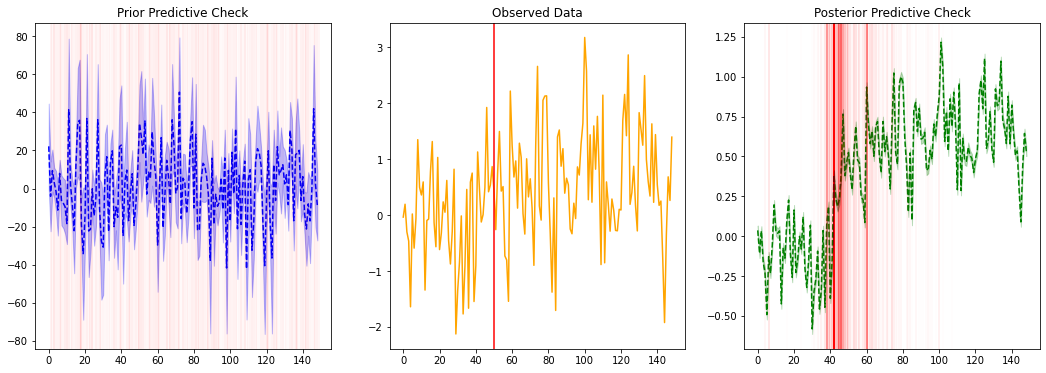

In [11]:
visualize_time_series(
    obs_time_series[1:], 
    prpc=prpc['observed_time_series'], 
    popc=popc['observed_time_series'], 
    change_points=[prpc['change_point'], 50, popc['change_point']],
    figsize=(18, 6)
)

# Estimate Latent Ability From Censored Data

C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:29: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 35 seconds.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1698: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


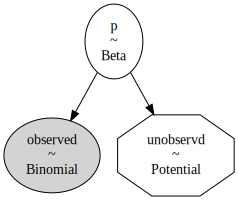

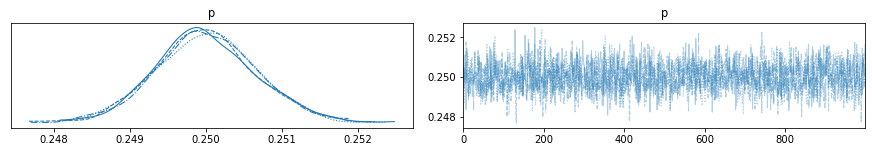

In [12]:
model = estimate_censored_data(
    n_censored_attempts=900, 
    observed_attempt=16, 
    n=30,
    beta_kwargs={
        'alpha': 5,
        'beta': 5
    },
    lower_bound=0, 
    upper_bound=15
)
plate, prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS
)
plate

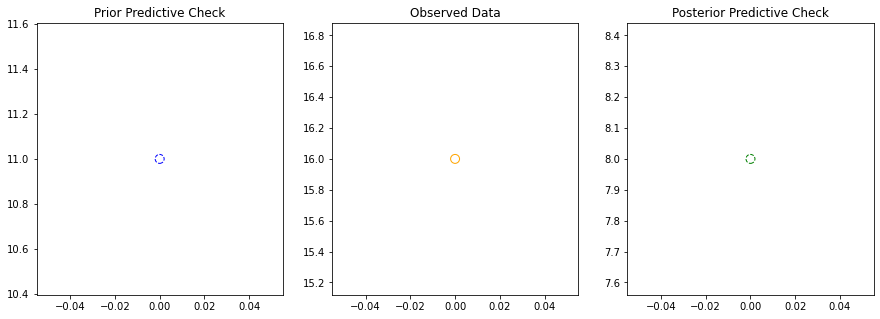

In [13]:
visualize_samples(
    observed=np.array([16]), 
    prpc=prpc['observed'][0], 
    popc=popc['observed'][0],
    s=80
)

# Estimate Size of Population through capture-recapture 

C:\Users\penthotal\Desktop\git_repositories\learning_bayes\books\bayesian_cognitive_modelling\modules\utils.py:33: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(**sampling_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [population_size]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 33 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\penthotal\miniconda3\envs\bayes_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


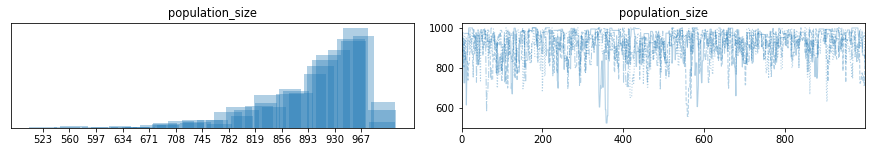

In [20]:
model = estimate_recapture(
    observed_recaptured=4, 
    first_sample=100, 
    second_sample=100,
    discrete_uniform_kwargs={
        'lower': 196,
        'upper': 1000
    }
)
prpc, trace, popc = validate_model(
    model,
    PRPC_KWARGS,
    SAMPLING_KWARGS,
    POPC_KWARGS,
    show_plate=False
)

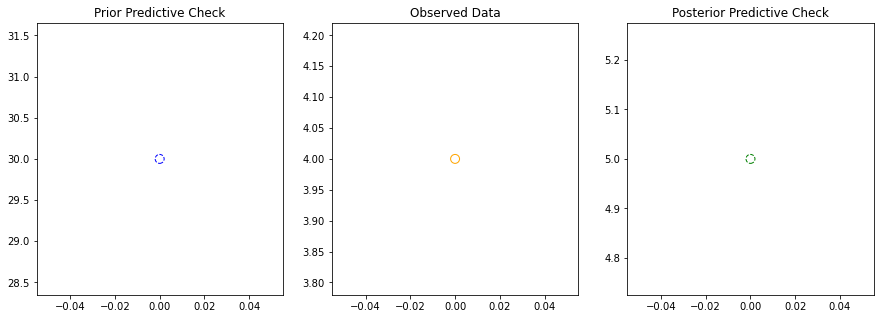

In [21]:
visualize_samples(
    observed=np.array([4]), 
    prpc=prpc['recaptured'][0], 
    popc=popc['recaptured'][0],
    s=80
)